In [1]:
import torch
import numpy as np
import argparse
import pickle
from collections import defaultdict
from pathlib import Path
from tqdm.auto import tqdm

from data_processing import load_dataset
from model import HeteroRGCN, HeteroLinkPredictionModel
from utils import set_config_args, get_comp_g_edge_labels, get_comp_g_path_labels
from utils import hetero_src_tgt_khop_in_subgraph, eval_edge_mask_auc, eval_edge_mask_topk_path_hit

parser = argparse.ArgumentParser(description='Explain link predictor')
'''
Dataset args
'''
parser.add_argument('--dataset_dir', type=str, default='datasets')
parser.add_argument('--dataset_name', type=str, default='aug_citation')
parser.add_argument('--valid_ratio', type=float, default=0.1) 
parser.add_argument('--test_ratio', type=float, default=0.2)
parser.add_argument('--max_num_samples', type=int, default=-1, 
                    help='maximum number of samples to explain, for fast testing. Use all if -1')

'''
GNN args
'''
parser.add_argument('--emb_dim', type=int, default=128)
parser.add_argument('--hidden_dim', type=int, default=128)
parser.add_argument('--out_dim', type=int, default=128)
parser.add_argument('--saved_model_dir', type=str, default='saved_models')
parser.add_argument('--saved_model_name', type=str, default='')

'''
Link predictor args
'''
parser.add_argument('--src_ntype', type=str, default='user', help='prediction source node type')
parser.add_argument('--tgt_ntype', type=str, default='item', help='prediction target node type')
parser.add_argument('--pred_etype', type=str, default='likes', help='prediction edge type')
parser.add_argument('--link_pred_op', type=str, default='dot', choices=['dot', 'cos', 'ele', 'cat'],
                   help='operation passed to dgl.EdgePredictor')

'''
Explanation args
'''
parser.add_argument('--num_hops', type=int, default=2, help='computation graph number of hops') 
parser.add_argument('--saved_explanation_dir', type=str, default='saved_explanations',
                    help='directory of saved explanations')
parser.add_argument('--eval_explainer_names', nargs='+', default=['pagelink'],
                    help='name of explainers to evaluate') 
parser.add_argument('--eval_path_hit', default=False, action='store_true', 
                    help='Whether to save the explanation') 
parser.add_argument('--config_path', type=str, default='', help='path of saved configuration args')

args = parser.parse_args('')

if args.config_path:
    args = set_config_args(args, args.config_path, args.dataset_name, 'train_eval')

if 'citation' in args.dataset_name:
    args.src_ntype = 'author'
    args.tgt_ntype = 'paper'

elif 'synthetic' in args.dataset_name:
    args.src_ntype = 'user'
    args.tgt_ntype = 'item'    
    
if args.link_pred_op in ['cat']:
    pred_kwargs = {"in_feats": args.out_dim, "out_feats": 1}
else:
    pred_kwargs = {}

g, processed_g, pred_pair_to_edge_labels, pred_pair_to_path_labels = load_dataset(args.dataset_dir,
                                                                                  args.dataset_name,
                                                                                  args.valid_ratio,
                                                                                  args.test_ratio)
mp_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = [g for g in processed_g]
encoder = HeteroRGCN(mp_g, args.emb_dim, args.hidden_dim, args.out_dim)
model = HeteroLinkPredictionModel(encoder, args.src_ntype, args.tgt_ntype, args.link_pred_op, **pred_kwargs)

if not args.saved_model_name:
    args.saved_model_name = f'{args.dataset_name}_model'

state = torch.load(f'{args.saved_model_dir}/{args.saved_model_name}.pth', map_location='cpu')
model.load_state_dict(state)    

test_src_nids, test_tgt_nids = test_pos_g.edges()
comp_graphs = defaultdict(list)
comp_g_labels = defaultdict(list)


/home/younggun0816/anaconda3/envs/GRNXAI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
print(len(test_src_nids), len(test_tgt_nids))
print("Source nodes:", test_src_nids)
print("Target nodes:", test_tgt_nids)


901 901
Source nodes: tensor([2215, 6100, 2902,  351, 3571, 7524, 2003, 3210, 1322, 5513,  690,  759,
        1990, 1043, 6980, 2279, 2760,  488,  374, 5659, 1135,  617, 6005, 1887,
         543, 1682, 5922,  509, 1070, 3696, 1975, 2309,  783,  269,  762, 2037,
          26,  286,  662,  939,  168,   23, 2322, 1949, 1860, 2956, 3367, 5318,
        6729,  562,  312,  643, 1374, 2370, 5046, 2274, 1936, 2484, 1267, 1704,
         848, 1302, 5562, 3312, 1038, 5737, 4073,  575, 4090, 2959,  411,  641,
          96,  430,  247, 6017, 4238, 5303, 4243, 4296, 2683, 4325, 5860, 4968,
         460, 5734,  735, 5789, 4784, 1976, 1722, 5756,  535, 5757, 2596, 2521,
        6089, 4658, 1736, 1245,  728, 7562, 1831, 1707, 6926, 5687,  881, 5579,
        6091, 4322, 3652, 2226, 3957, 5032, 2255, 4848, 5452,  472,   96,  199,
        1156, 3426, 1364, 3836,  858, 2637, 5524, 3016, 2185, 1507,  512, 2760,
        3209, 2780,  287,  617, 1507, 6631,  227, 7432,   49, 1389, 2654, 3837,
        3493, 2920

In [6]:
src_nid, tgt_nid = test_src_nids[i], test_tgt_nids[i]
print(f"Source Node: {src_nid}, Target Node: {tgt_nid}")
comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_feat_nids = hetero_src_tgt_khop_in_subgraph(
    args.src_ntype, src_nid, args.tgt_ntype, tgt_nid, mp_g, args.num_hops
)
print(comp_g)


Source Node: 2902, Target Node: 578
Graph(num_nodes={'author': 19, 'fos': 50, 'paper': 3665, 'ref': 110},
      num_edges={('author', 'likes', 'paper'): 0, ('author', 'writes', 'paper'): 109, ('fos', 'of', 'paper'): 14028, ('paper', 'cites', 'ref'): 941, ('paper', 'in', 'fos'): 14028, ('paper', 'written_by', 'author'): 109, ('ref', 'cited_by', 'paper'): 941},
      metagraph=[('author', 'paper', 'likes'), ('author', 'paper', 'writes'), ('paper', 'ref', 'cites'), ('paper', 'fos', 'in'), ('paper', 'author', 'written_by'), ('fos', 'paper', 'of'), ('ref', 'paper', 'cited_by')])


In [7]:
with torch.no_grad():
    pred = model(comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_feat_nids).sigmoid().item() > 0.5
print(f"Prediction for i={i}: {pred}")

Prediction for i=2: True


## Pick one example graph

In [5]:
i = 2
# Get the k-hop subgraph
src_nid, tgt_nid = test_src_nids[i], test_tgt_nids[i]
comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_feat_nids = hetero_src_tgt_khop_in_subgraph(args.src_ntype, 
                                                                                            src_nid,
                                                                                            args.tgt_ntype,
                                                                                            tgt_nid,
                                                                                            mp_g,
                                                                                            args.num_hops)

with torch.no_grad():
    pred = model(comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_feat_nids).sigmoid().item() > 0.5

if pred:
    src_tgt = ((args.src_ntype, int(src_nid)), (args.tgt_ntype, int(tgt_nid)))
    comp_graphs[src_tgt] = [comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_feat_nids]


## Load saved explanation

In [8]:
explainer = args.eval_explainer_names[0]
saved_explanation_mask = f'{explainer}_{args.saved_model_name}_pred_edge_to_comp_g_edge_mask'
saved_file = Path.cwd().joinpath(args.saved_explanation_dir, saved_explanation_mask)
with open(saved_file, "rb") as f:
    explanation_mask = pickle.load(f)

## Extract paths and construct the explanation graph to plot

In [9]:
import dgl
def get_exp_g(g, paths, src_ntype, src_nid, tgt_ntype, tgt_nid):
    path_eids = {}
    for path in paths:
        for edge in path:
            etype, u, v = edge
            eids = comp_g.edge_ids(u=u, v=v, etype=etype)
            path_eids[etype] = eids

    exp_g = g
    for etype in g.canonical_etypes:
        # hard_edge_mask = hard_edge_mask_dict[etype]
        remove_eids = g.edges(form='eid', etype=etype)
        if etype in path_eids:
            remove_eids = remove_eids[remove_eids != path_eids[etype]]
        exp_g = dgl.remove_edges(exp_g, remove_eids, etype=etype) # creates a new graph

    exp_g = dgl.compact_graphs(exp_g, always_preserve={src_ntype : src_nid, tgt_ntype : tgt_nid })

    # Get src and tgt nid in the explanation graph
    # Note: the input graph should have node data dgl.NID
    exp_g_src_nid_in_g = exp_g.ndata[dgl.NID][src_ntype]
    exp_g_src_nid = (exp_g_src_nid_in_g == src_nid).nonzero().view(-1)
    exp_g_tgt_nid_in_g = exp_g.ndata[dgl.NID][tgt_ntype]
    exp_g_tgt_nid = (exp_g_tgt_nid_in_g == tgt_nid).nonzero().view(-1)

    return exp_g, exp_g_src_nid, exp_g_tgt_nid   

comp_g_edge_mask_dict = explanation_mask[src_tgt]
from explainer import PaGELink
pagelink = PaGELink(model)
paths = pagelink.get_paths(comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_edge_mask_dict)

exp_g, exp_g_src_nid, exp_g_tgt_nid = get_exp_g(comp_g, 
                                                paths,
                                                args.src_ntype,
                                                comp_g_src_nid,
                                                args.tgt_ntype,
                                                comp_g_tgt_nid)

## Set plot arguments and plot

In [10]:
from utils import plot_hetero_graph

if 'synthetic' in args.dataset_name:
    ntypes_to_nshapes = {'user':'p', 'item':'o', 'attr':'s'}
    ntypes_to_nlayers = {'user': 0, 'item': 1, 'attr': 2, }
    ntypes_to_ncolors = {'user':'#FFBFB5', 'item':'#C5E0B4', 'attr':'#8FAADC'}
    
elif 'citation' in args.dataset_name:
    ntypes_to_nshapes = {'author':'p', 'paper':'o', 'ref':'^', 'fos':'s'}
    ntypes_to_nlayers = {'author': 0, 'paper': 1, 'fos': 2, 'ref': 3}
    ntypes_to_ncolors = {'author':'#FFBFB5', 'paper':'#C5E0B4', 'fos':'#8FAADC', 'ref':'#FFD966'}
    
edge_kwargs = {"edge_color" : '#00B050',
               "style" : '-',
               "width" : 4,
               "arrows" : True,
               "arrowstyle" : '-|>',
               "arrowsize" : 30}

selected_edge_kwargs = {"edge_color" : 'red',
                        "style" : '--',
                        "width" : 3,
                        "arrows" : False}
selected_edge_dict = {(args.src_ntype, args.pred_etype, args.tgt_ntype) : (exp_g_src_nid, exp_g_tgt_nid)}

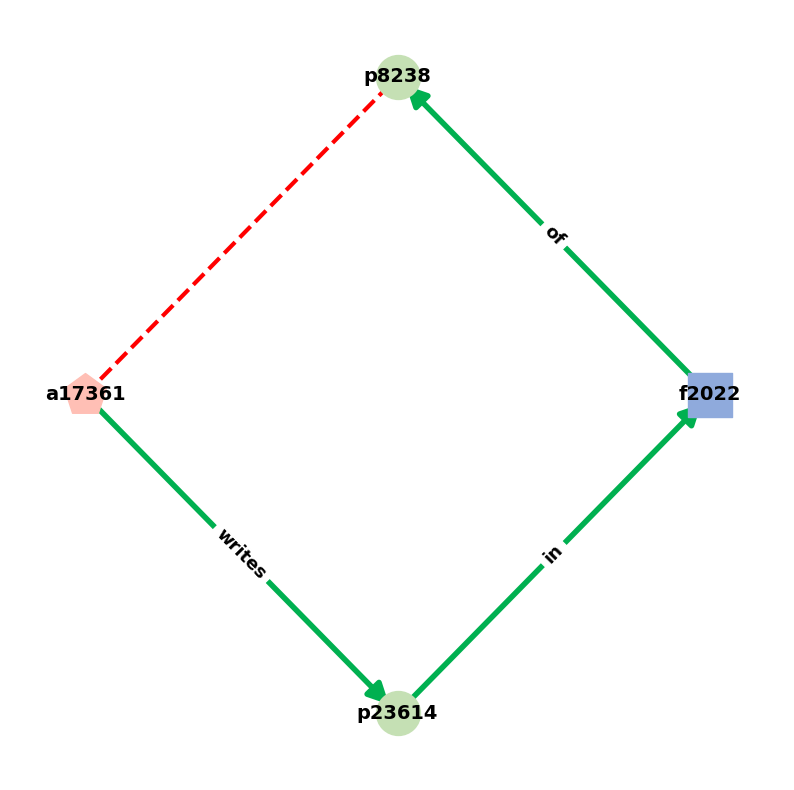

In [ ]:
nx_graph = plot_hetero_graph(exp_g,
                             ntypes_to_nshape,
                             ntypes_to_ncolors,
                             ntypes_to_nlayers,
                             label='nx_id',
                             edge_kwargs=edge_kwargs,
                             selected_edge_kwargs=selected_edge_kwargs,
                             selected_edge_dict=selected_edge_dict)